## Project - Part II


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal
from gaussian_process import (
    optimize_kernel_params,
    plot_grid_search_results,
    predict_conditional_mean_and_var,
    radial_basis_kernel,
    rational_quadratic_kernel,
    add_intermediate_points
)


### Data Loading


In [2]:
# Time steps in the simulation
n_steps = 100

# Speed flow: 3D array with shape (Time, X coordinates, Y coordinates, 2)
speed_flow = []

# Load the X and Y data for each time step
for i in range(n_steps):

    # Load the data for X and Y
    # The data is given in a matrix with data for each position in the grid
    Vx = pd.read_csv(f'./OceanFlow/{i+1}u.csv', header=None).values
    Vy = pd.read_csv(f'./OceanFlow/{i+1}v.csv', header=None).values

    # Construct the total velocity by concatenating the X and Y components as
    # columns in a single array
    V = np.stack([Vx, Vy], axis=2)

    # Add the current time step velocity to the speed_flow array
    speed_flow.append(V)

# Convert the speed_flow list to a numpy array
Vt = np.array(speed_flow)
print("Data Shape:", Vt.shape)
print("- Timesteps:", Vt.shape[0])
print("- Y coordinates:", Vt.shape[1])
print("- X coordinates:", Vt.shape[2])
print("- Velocity components:", Vt.shape[3])

# Get the X and Y velocities
Vx = Vt[:, :, :, 0]
Vy = Vt[:, :, :, 1]

# Load the mask data
mask = pd.read_csv('./OceanFlow/mask.csv', header=None).values

# The mask is flipped in the Y axis, so we flip it back
mask = np.flip(mask, axis=0)


Data Shape: (100, 504, 555, 2)
- Timesteps: 100
- Y coordinates: 504
- X coordinates: 555
- Velocity components: 2


### Part II


#### General Parameters


In [4]:
# =============== GENERAL PARAMS =============== #

# Folds to use for cross validation
num_folds = 20

# Folder where images will be saved
images_folder = "./Images/"

# Selected position for which to predict the velocity
selected_position = np.array([400, 200])

# Method used to predict the initial mean of the Gaussian Process
initial_mean_method: Literal["moving_average", "mean", "zero"] = "zero"

# =================== KERNEL =================== #

kernel_option: Literal["rbf", "rq"] = "rq"

if kernel_option == "rbf":

    # Prefix for the images
    images_prefix = "rbf"

    # Kernel to use for the Gaussian Process
    selected_kernel = radial_basis_kernel

    # Create a range of values for the kernel parameters
    param_ranges = {
        "l": np.linspace(0.1, 5, 18),
        "sigma": np.linspace(0.1, 2, 5),
    }

    # Parameters to plot in the grid search plot
    plot_params = ["l", "sigma"]

elif kernel_option == "rq":

    # Prefix for the images
    images_prefix = "rq"

    # Kernel to use for the Gaussian Process
    # selected_kernel = radial_basis_kernel
    selected_kernel = rational_quadratic_kernel

    # Create a range of values for the kernel parameters
    param_ranges = {
        "l": np.linspace(0.1, 5, 18),
        "sigma": np.linspace(0.1, 2, 5),
        "alpha": np.linspace(0.5, 3, 6),
    }

    # Parameters to plot in the grid search plot
    plot_params = ["l", "alpha"]

else:
    raise ValueError("Invalid kernel test")


#### Problem 4.a (10 points)

Take into consideration that now measurements are considered to have 3 days between them, instead of the 3 hours used in the previous part.


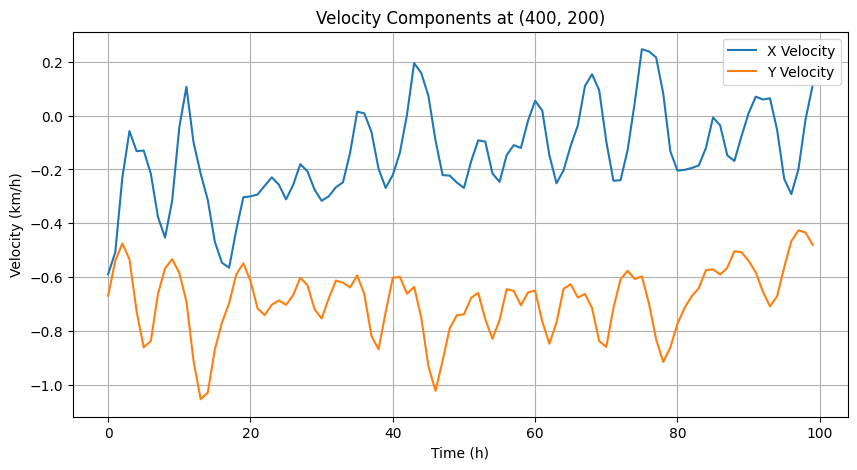

In [5]:
# Select a specific location to get the velocity data
x = selected_position[0]
y = selected_position[1]

# Get the velocity data for the selected location (Vl = Location Velocity)
V_loc = Vt[:, y, x, :]

# Get the X and Y velocity components
Vx_loc = V_loc[:, 0]
Vy_loc = V_loc[:, 1]

# ==================== PLOT ==================== #

# Plot the X and Y velocity components
plt.figure(figsize=(10, 5))
plt.plot(Vx_loc, label='X Velocity')
plt.plot(Vy_loc, label='Y Velocity')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Velocity (km/h)')
plt.title(f'Velocity Components at ({x}, {y})')
plt.grid()

# Save the plot
plt.savefig(f'{images_folder}{images_prefix}_selected_location_velocities.png')

plt.show()


General parameters of the entire problem


In [6]:
# ================ OPTIMIZATION ================ #

# Optimize the kernel parameters for the X component
optimal_params_x, x_results_df = optimize_kernel_params(
    data=Vx_loc,
    param_ranges=param_ranges,
    num_folds=num_folds,
    mean_prediction_method=initial_mean_method,
    kernel=selected_kernel
)

# Optimize the kernel parameters for the Y component
optimal_params_y, y_results_df = optimize_kernel_params(
    data=Vy_loc,
    param_ranges=param_ranges,
    num_folds=num_folds,
    mean_prediction_method=initial_mean_method,
    kernel=selected_kernel
)


100%|██████████| 540/540 [01:26<00:00,  6.25it/s]



X Velocity (Vx)
- Optimal 'l': 3.8470588235294123
- Optimal 'sigma': 0.1
- Optimal 'alpha': 0.5

Y Velocity (Vy)
- Optimal 'l': 4.135294117647059
- Optimal 'sigma': 0.1
- Optimal 'alpha': 0.5


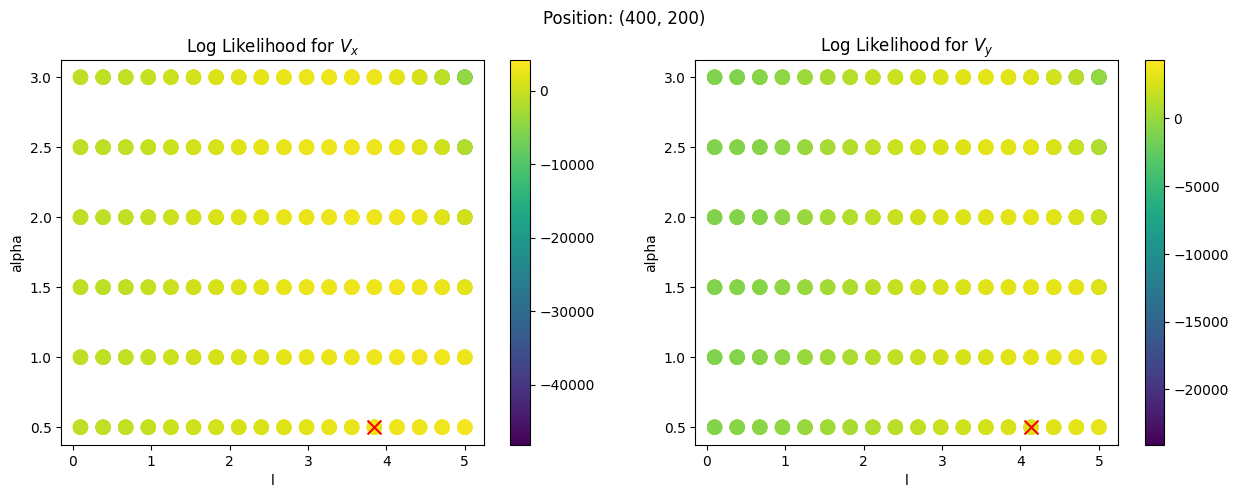

In [16]:
# =================== RESULTS ================== #

print()
print("X Velocity (Vx)")
for param, value in optimal_params_x.items():
    print(f"- Optimal '{param}': {value}")

print()
print("Y Velocity (Vy)")
for param, value in optimal_params_y.items():
    print(f"- Optimal '{param}': {value}")

# ==================== PLOT ==================== #

# Plot the results of the grid search
plot_grid_search_results(
    x_results_df=x_results_df,
    y_results_df=y_results_df,
    position=selected_position,
    params_to_plot=plot_params,
    save_to_file=True,
    filename=f'{images_folder}{images_prefix}_grid_search_results_selected_pos.png'
)


#### Zooming into the Search Space


In [20]:
# Create a new range of values for the zoomed in grid search
if kernel_option == "rbf":
    param_ranges_zoom = {
        "l": np.linspace(0.8, 1.2, 25),
        "sigma": np.linspace(0.1, 1, 5),
    }

elif kernel_option == "rq":
    param_ranges_zoom = {
        "l": np.linspace(2, 5, 25),
        "sigma": np.linspace(0.01, 0.5, 10),
        "alpha": np.linspace(0.1, 1, 10),
    }

else:
    raise ValueError(f"Invalid kernel test: {kernel_option}")

# ================ OPTIMIZATION ================ #

# Optimize the kernel parameters for the X component
optimal_params_x, x_results_df = optimize_kernel_params(
    data=Vx_loc,
    param_ranges=param_ranges_zoom,
    num_folds=num_folds,
    kernel=selected_kernel,
    mean_prediction_method=initial_mean_method
)

# Optimize the kernel parameters for the Y component
optimal_params_y, y_results_df = optimize_kernel_params(
    data=Vy_loc,
    param_ranges=param_ranges_zoom,
    num_folds=num_folds,
    kernel=selected_kernel,
    mean_prediction_method=initial_mean_method
)


100%|██████████| 2500/2500 [03:26<00:00, 12.13it/s]



X Velocity (Vx)
- Optimal 'l': 2.625
- Optimal 'sigma': 0.01
- Optimal 'alpha': 0.1

Y Velocity (Vy)
- Optimal 'l': 3.0
- Optimal 'sigma': 0.01
- Optimal 'alpha': 0.1


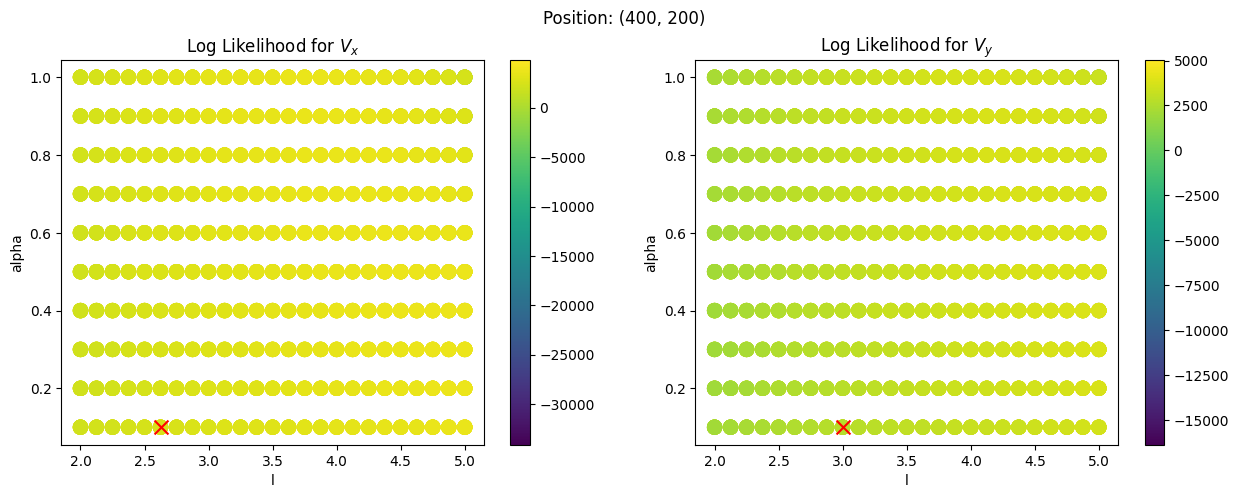

In [21]:
# =================== RESULTS ================== #

print()
print("X Velocity (Vx)")
for param, value in optimal_params_x.items():
    print(f"- Optimal '{param}': {value}")

print()
print("Y Velocity (Vy)")
for param, value in optimal_params_y.items():
    print(f"- Optimal '{param}': {value}")

# ==================== PLOT ==================== #

# Plot the results of the grid search
plot_grid_search_results(
    x_results_df=x_results_df,
    y_results_df=y_results_df,
    position=selected_position,
    params_to_plot=plot_params,
    save_to_file=True,
    filename=f'{images_folder}{images_prefix}_grid_search_results_selected_pos_zoom.png'
)

#### Problem 4.b (5 points)


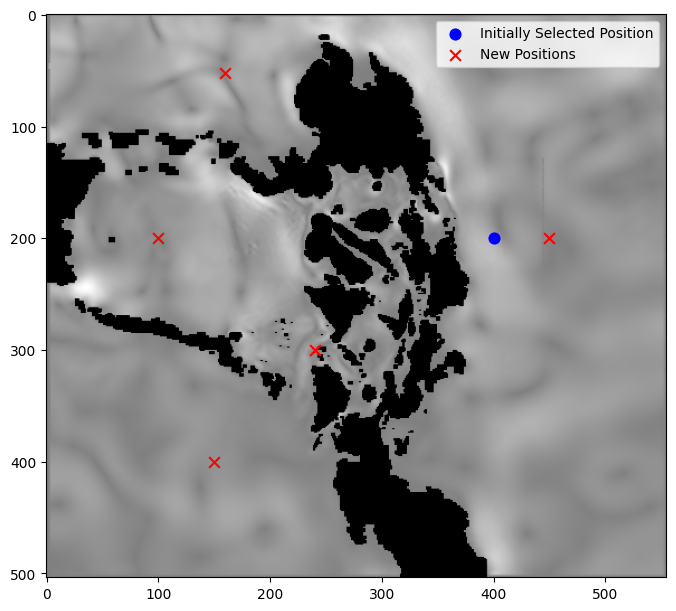

In [22]:
# Different positions to test for the prediction
positions = np.array([
    [150, 400],
    [240, 300],
    [450, 200],
    [160, 52],
    [100, 200]
])

# Get all of the X and Y components
Vx = Vt[:, :, :, 0]
Vy = Vt[:, :, :, 1]

# Calculate the speed
speed = np.sqrt(Vx**2 + Vy**2)

# Plot the mask and the speed
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.imshow(speed[0], cmap='gray', alpha=0.5)

# Plot the initial selected position and the new ones
plt.scatter(
    selected_position[0],
    selected_position[1],
    c='b',
    s=60,
    marker='o',
    label="Initially Selected Position"
)
plt.scatter(
    positions[:, 0],
    positions[:, 1],
    c='r',
    s=60,
    marker='x',
    label="New Positions"
)
plt.legend()

# Save the plot
plt.savefig(
    f'{images_folder}{images_prefix}_selected_position_and_new_positions.png'
)
plt.show()


100%|██████████| 180/180 [00:13<00:00, 13.44it/s]


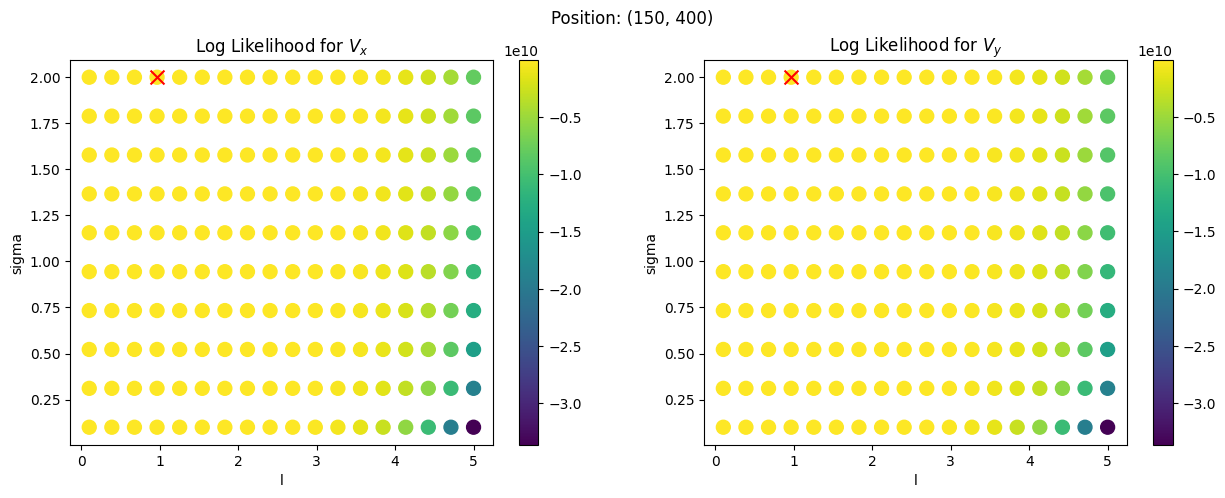

100%|██████████| 180/180 [00:17<00:00, 10.12it/s]


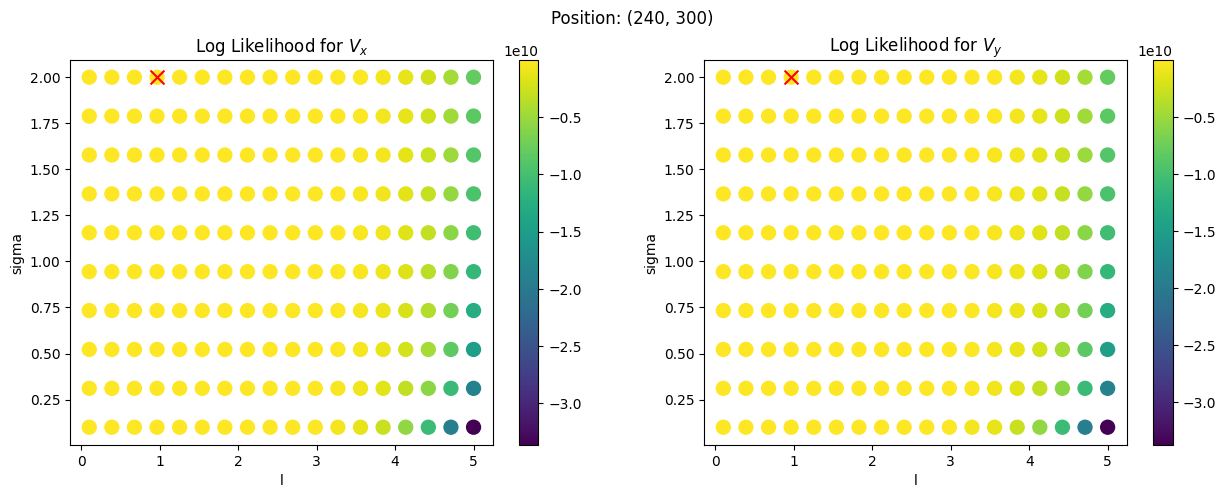

100%|██████████| 180/180 [00:14<00:00, 12.35it/s]


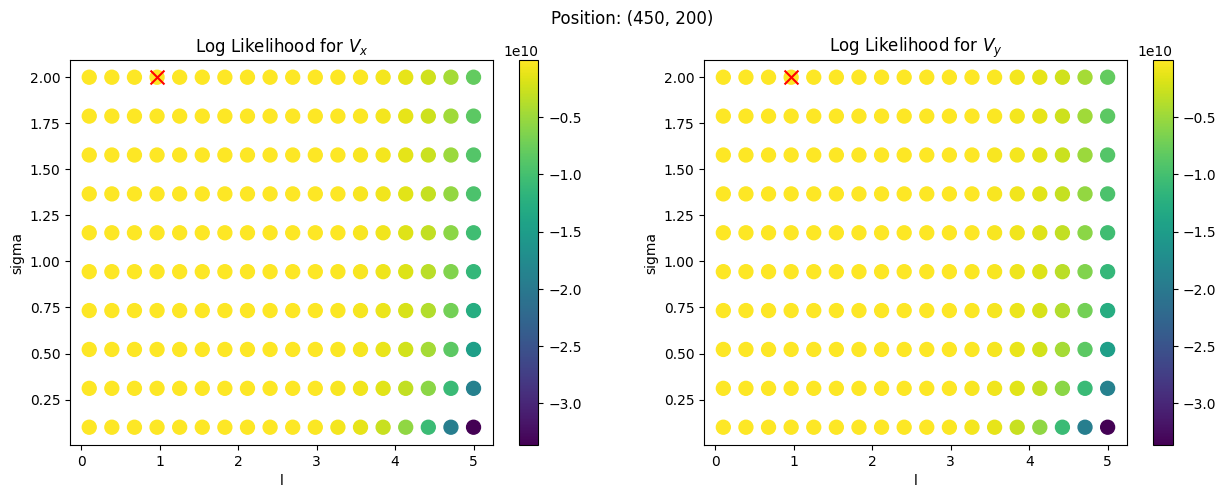

100%|██████████| 180/180 [00:14<00:00, 12.32it/s]


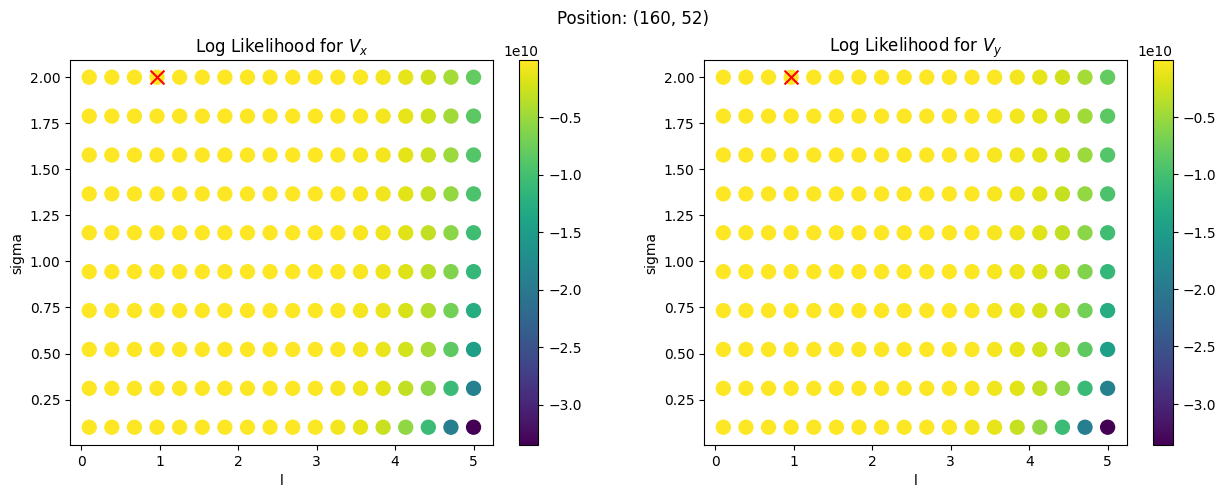

100%|██████████| 180/180 [00:14<00:00, 12.72it/s]


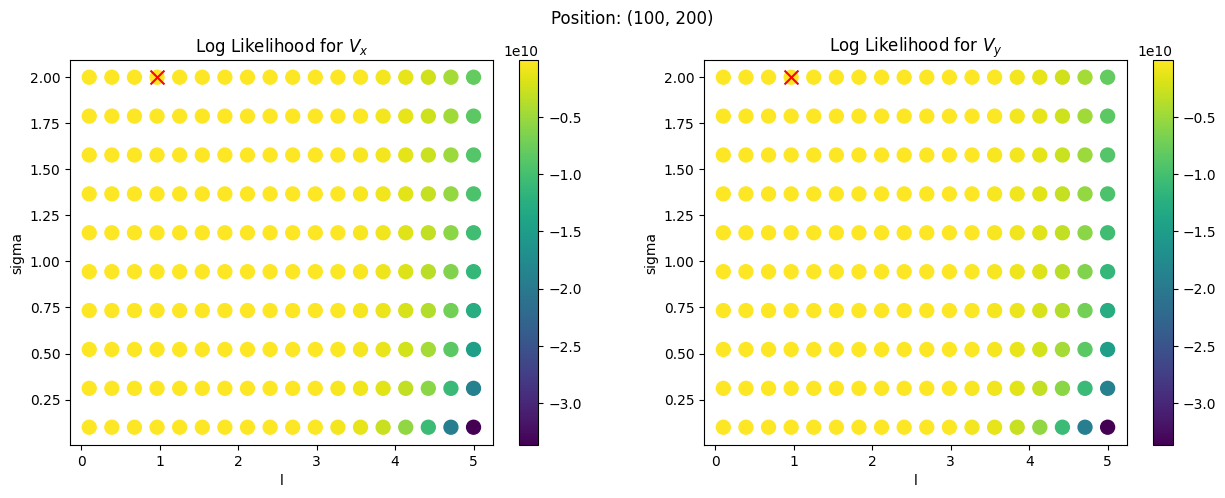

In [8]:
# ========== OPTIMIZING EACH POSITION ========== #

for position in positions:

    # Get the velocity data for the selected location
    x = position[0]
    y = position[1]
    V_pos = Vt[:, y, x, :]

    # Get the X and Y velocity components
    Vx_pos = V_pos[:, 0]
    Vy_pos = V_pos[:, 1]

    # Optimize the kernel parameters for the X component
    optimal_pos_params_x, x_results_df = optimize_kernel_params(
        data=Vx_pos,
        param_ranges=param_ranges,
        num_folds=num_folds,
        kernel=selected_kernel
    )

    # Optimize the kernel parameters for the Y component
    optimal_pos_params_y, y_results_df = optimize_kernel_params(
        data=Vy_pos,
        param_ranges=param_ranges,
        num_folds=num_folds,
        kernel=selected_kernel
    )

    # Plot the results of the grid search
    plot_grid_search_results(
        x_results_df=x_results_df,
        y_results_df=y_results_df,
        position=position,
        params_to_plot=plot_params,
        save_to_file=True,
        filename=f'{images_folder}{images_prefix}_grid_search_results_{position[0]}_{position[1]}.png'
    )


#### Problem 4.c (5 points)


100%|██████████| 180/180 [00:06<00:00, 29.16it/s]


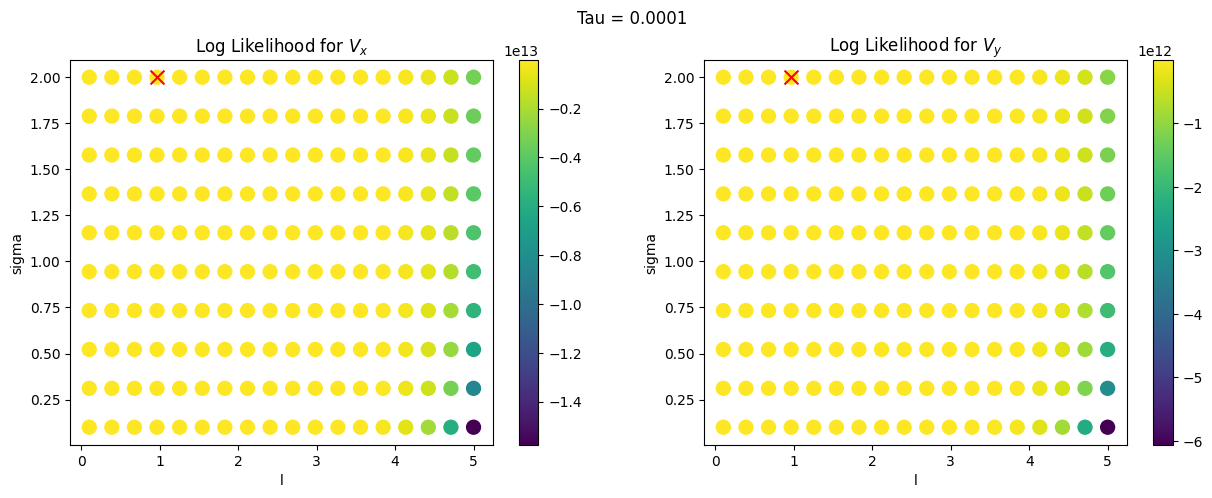

100%|██████████| 180/180 [00:06<00:00, 28.11it/s]


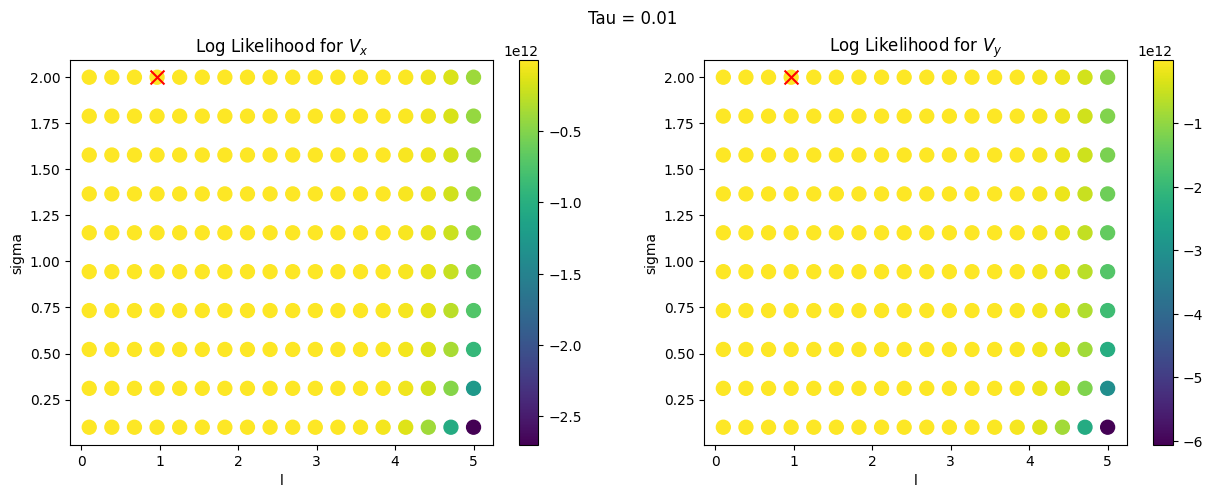

100%|██████████| 180/180 [00:06<00:00, 28.23it/s]


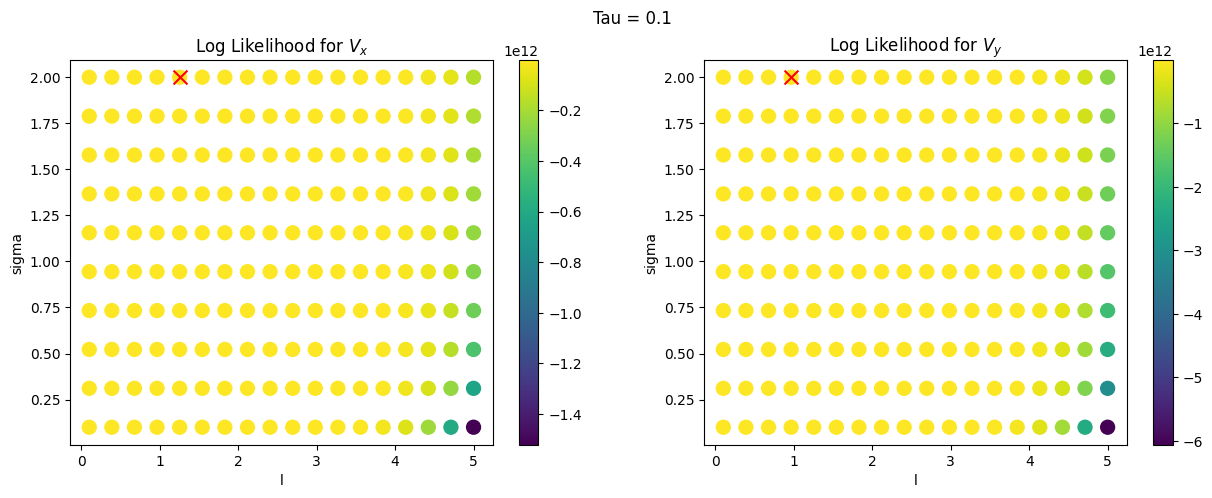

100%|██████████| 180/180 [00:06<00:00, 29.18it/s]


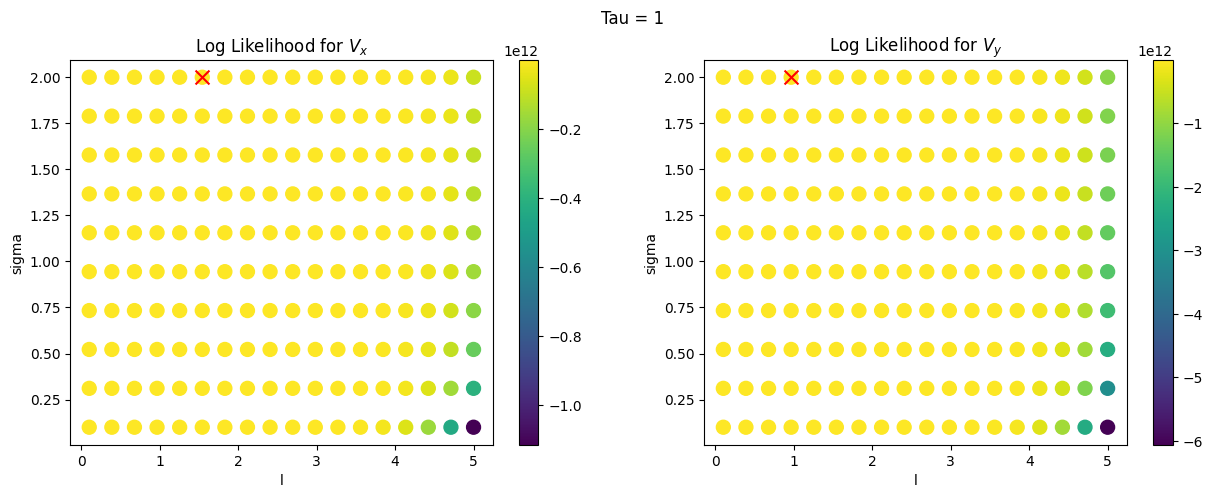

In [9]:
# Values of Tau to test
tau_values = [0.0001, 0.01, 0.1, 1]

for tau in tau_values:

    # Optimize the kernel parameters for the X component
    optimal_tau_params_x, x_results_df = optimize_kernel_params(
        data=Vx_loc,
        param_ranges=param_ranges,
        tau=tau
    )

    # Optimize the kernel parameters for the Y component
    optimal_tau_params_y, y_results_df = optimize_kernel_params(
        data=Vy_loc,
        param_ranges=param_ranges,
    )

    # Plot the results of the grid search
    plot_grid_search_results(
        x_results_df=x_results_df,
        y_results_df=y_results_df,
        position=position,
        params_to_plot=plot_params,
        custom_title_text=f'Tau = {tau}',
        save_to_file=True,
        filename=f'{images_folder}{images_prefix}_grid_search_results_tau_{tau}.png'
    )


#### Problem 4.d (10 points)


In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

# Get the "Xs" and "Ys" for the Gaussian Process
y_x = Vx_loc
y_y = Vy_loc
X = np.arange(0, len(y_x)).reshape(-1, 1)

# Split the data into training and testing sets
# (There's no need for re-defining X because it's the same for both components)
X_train, X_test, y_x_train, y_x_test = train_test_split(
    X, y_x, test_size=0.2, random_state=42
)
_, _, y_y_train, y_y_test = train_test_split(
    X, y_y, test_size=0.2, random_state=42
)

# Fit the Gaussian Process to the training data
gpr_fit = GaussianProcessRegressor(kernel=RBF()).fit(X_train, y_x_train)
params_x = gpr_fit.kernel_.get_params()
score_x = gpr_fit.score(X_test, y_x_test)
print("X - Kernel parameters: ", params_x)
print("X - Score: ", score_x)

gpr_fit = GaussianProcessRegressor(kernel=RBF()).fit(X_train, y_y_train)
params_y = gpr_fit.kernel_.get_params()
score_y = gpr_fit.score(X_test, y_y_test)
print("Y - Kernel parameters: ", params_y)
print("Y - Score: ", score_y)


X - Kernel parameters:  {'length_scale': 1.747079835442446, 'length_scale_bounds': (1e-05, 100000.0)}
X - Score:  0.8543166810747069
Y - Kernel parameters:  {'length_scale': 1.9011429770930213, 'length_scale_bounds': (1e-05, 100000.0)}
Y - Score:  0.8882170657557578


#### Problem 5 (15 points)


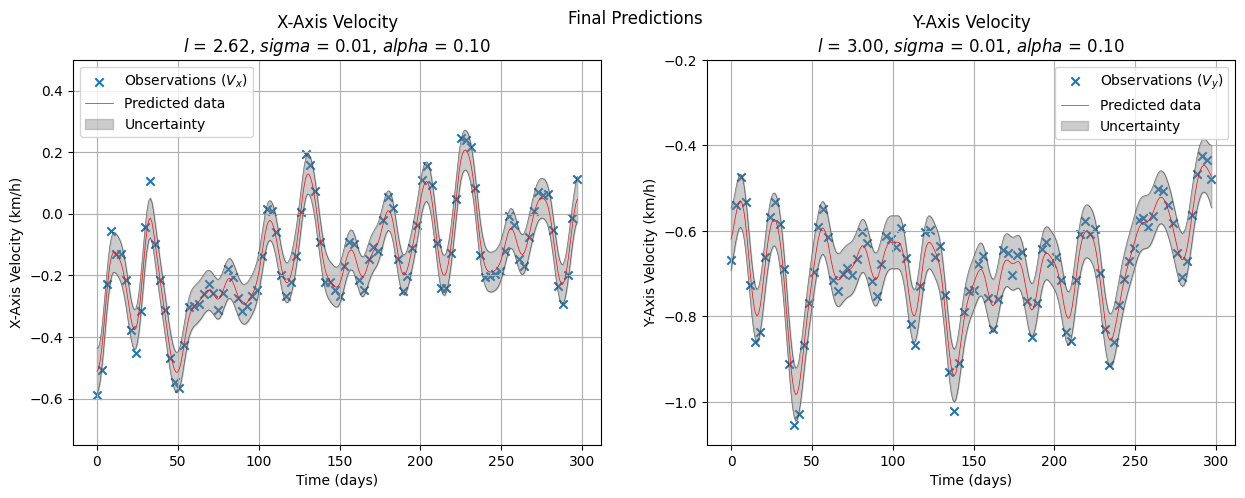

In [23]:

# Get the full range of values for X
# (For the Philippines dataset, this is just the X axis of the data, or
# a range from 0 to the number of timesteps)
X = np.arange(Vx_loc.shape[0])

# Currently we have measurements for every 3 days. We previously assumed that
# ocean currents remain constant for about 3 hours, therefore, we can predict
# the velocity at smaller time intervals by having 24 measurements in between
# each of the original measurements (i.e. 24 * 3 = 72 hours = 3 days).
X_pred = add_intermediate_points(X, 2)

# ================= PREDICTIONS ================ #

# Turn the optimal parameters into a tuple
optimal_params_vx = tuple(optimal_params_x.values())
optimal_params_vy = tuple(optimal_params_y.values())

# Calculate the conditional mean and variance of the X component
conditional_mean_x, conditional_variance_x, _ = predict_conditional_mean_and_var(
    x1=X_pred,
    x2=X,
    y2=Vx_loc,
    kernel=selected_kernel,
    kernel_args=optimal_params_vx,
    mean_prediction_method=initial_mean_method
)

# Calculate the conditional mean and variance of the Y component
conditional_mean_y, conditional_variance_y, _ = predict_conditional_mean_and_var(
    x1=X_pred,
    x2=X,
    y2=Vy_loc,
    kernel=selected_kernel,
    kernel_args=optimal_params_vy,
    mean_prediction_method=initial_mean_method
)

# Extract the variance along the diagonal
var_x = np.sqrt(np.diagonal(conditional_variance_x))
var_y = np.sqrt(np.diagonal(conditional_variance_y))

# ============== PLOT X COMPONENT ============== #

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Convert the "X" values to days by multiplying by 3
t_days = X * 3

# Convert the "X_pred" values to days by multiplying by 3
t_pred_days = X_pred * 3

# Plot the results
ax1.scatter(
    t_days,
    Vx_loc,
    label='Observations ($V_x$)',
    marker='x',
)
ax1.plot(
    t_pred_days,
    conditional_mean_x,
    label='Predicted data',
    color='red',
    linewidth=0.5
)
ax1.plot(
    t_pred_days,
    conditional_mean_x + 3*var_x,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax1.plot(
    t_pred_days,
    conditional_mean_x - 3*var_x,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax1.fill_between(
    t_pred_days,
    conditional_mean_x + 3*var_x,
    conditional_mean_x - 3*var_x,
    label="Uncertainty",
    color="gray",
    alpha=0.4
)

# Build the title string for the X component
vx_title = f"X-Axis Velocity\n"

# For each optimal parameter, add it to the title string
for key, value in optimal_params_x.items():
    vx_title += f"${key}$ = {value:.2f}, "

# Remove the trailing comma and space
vx_title = vx_title[:-2]

ax1.legend()
ax1.grid()
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('X-Axis Velocity (km/h)')
ax1.set_title(vx_title)

# ============== PLOT Y COMPONENT ============== #

ax2.scatter(
    t_days,
    Vy_loc,
    label='Observations ($V_y$)',
    marker='x',
)
ax2.plot(
    t_pred_days,
    conditional_mean_y,
    label='Predicted data',
    color='red',
    linewidth=0.5
)
ax2.plot(
    t_pred_days,
    conditional_mean_y + 3*var_y,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax2.plot(
    t_pred_days,
    conditional_mean_y - 3*var_y,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax2.fill_between(
    t_pred_days,
    conditional_mean_y + 3*var_y,
    conditional_mean_y - 3*var_y,
    label="Uncertainty",
    color="gray",
    alpha=0.4
)

ax2.legend()
ax2.grid()
ax2.set_xlabel(
    'Time (days)'
)
ax2.set_ylabel(
    'Y-Axis Velocity (km/h)'
)

# Build the title string for the Y component
vy_title = f"Y-Axis Velocity\n"

# For each optimal parameter, add it to the title string
for key, value in optimal_params_y.items():
    vy_title += f"${key}$ = {value:.2f}, "

# Remove the trailing comma and space
vy_title = vy_title[:-2]
ax2.set_title(vy_title)

# Set max value of Y for the X component
ax1.set_ylim([-0.75, 0.5])

# Set max value of Y for the Y component
ax2.set_ylim([-1.1, -0.2])

# Super title with the parameters used
fig.suptitle("Final Predictions")

# Save the figure
plt.savefig(f"{images_folder}{images_prefix}_final_predictions.png")

plt.show()


#### Problem 6.a (15 points)


In [ ]:
# Make two arrays, one for all the possible X coordinates
# and one for all the possible Y coordinates
x_coords = np.arange(Vt.shape[2])
y_coords = np.arange(Vt.shape[1])

# Create a meshgrid from the X and Y coordinates
*coordinates, = np.meshgrid(x_coords, y_coords)

#

# Create a

x_coords
